# Malus with two polarizers: continuous movement

Author: Luis Miguel Sanchez Brea

Date:   17/01/2018

Purpose: Ecograb project, polariscope callibration

We have diode laser at 850 nm (current = 316 mA)
We have lens for collimating and Thorlabs DG10-600-B diffuser

We have polarizer 1 Thorlabs LPNIRE100-B
We have polarizer 4 Thorlabs LPNIRE100-B

Polarizer 1 is placed at 0º, as we have a $\lambda/4$ and circular light

We rotate polarizer 4 in order to determine the polarization parameters of LPNIRE100-B. We assume that polarizers do not present depolarization and then, Jones Matrix formalism is valid:

\begin{equation}
P_L(0)=\left[\begin{array}{cc}
p_1 & 0  \\
0 & p_2
\end{array}\right]
\end{equation}

After this formalism, we pass to Mueller using Jones-Mueller Transformation.

**This example is with continuous movement**: We start at $\theta=0$ and go to $\theta=360$, the function continuously ask the the positions to motors and intensities to labjack. 

This data are stored in a list
The list is converted to a numpy array

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import hickle as hkl
import time
import pprint
from __future__ import print_function

### Motors definition

In [3]:
from polarimeter.motors.rotary_motors import Motors
Comports = [3, 4, 5, 7] 
Vels = [600, 600, 600, 600]

In [4]:
motors = Motors(RS232_COMPORT=Comports, init_vels=Vels) 

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0



### Labjack definition

In [5]:
import u3
import LabJackPython


V=1.
mV=V/1000


def to_bits(variable_integer, num_bits=16, verbose=True):
    """
    takes an integer an generates a list with bits

    Args:
        variable_integer (int): integer with data
        num_bits (int): num of output bits: 8,16, 32, 64
    """
    if num_bits == 8:
        output = map(int, [x for x in '{:08b}'.format(variable_integer)])
    elif num_bits == 16:
        output = map(int, [x for x in '{:016b}'.format(variable_integer)])
    elif num_bits == 32:
        output = map(int, [x for x in '{:032b}'.format(variable_integer)])
    elif num_bits == 64:
        output = map(int, [x for x in '{:064b}'.format(variable_integer)])

    if verbose is True:
        print( output)
    return output

In [6]:
# loads labjack
d=u3.U3()

In [7]:
print("\n Callibration data:")
data_callibration=d.getCalibrationData()
pprint.pprint(data_callibration)


 Callibration data:
{'dac0Offset': -0.6872114308644086,
 'dac0Slope': 50.9896679460071,
 'dac1Offset': -0.701979405945167,
 'dac1Slope': 50.91950369440019,
 'hvAIN0Offset': -10.518997645704076,
 'hvAIN0Slope': 0.00031980290077626705,
 'hvAIN1Offset': -10.489001986570656,
 'hvAIN1Slope': 0.0003192389849573374,
 'hvAIN2Offset': -10.523998295888305,
 'hvAIN2Slope': 0.0003195337485522032,
 'hvAIN3Offset': -10.51609767600894,
 'hvAIN3Slope': 0.00031975959427654743,
 'lvDiffOffset': -2.490987469209358,
 'lvDiffSlope': 7.56862573325634e-05,
 'lvSEOffset': 0.001728925621137023,
 'lvSESlope': 3.775535151362419e-05,
 'tempSlope': 0.01259785215370357,
 'vRef1.5AtCal': 0.0,
 'vRefAtCAl': 2.486867640633136,
 'vRegAtCal': 0.0}


In [8]:
AIN_number=1
ain1bits, = d.getFeedback(u3.AIN(AIN_number)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)


0.942738318117


In [9]:
def get_intensity(AIN_number=1, verbose=True):
    ain1bits, = d.getFeedback(u3.AIN(AIN_number)) # Read from raw bits from AIN0
    ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
    if verbose is True:
        print("{:2.2f}".format(ainValue), end=', ')
    return ainValue

### Experiment

In [11]:
# Move motor 1 to maximum position of laser diode
angle1_max=0


In [13]:
positions=sp.linspace(0,360,90)
intensities=sp.zeros_like(positions,dtype=float)


In [21]:
motors.VELS=[50,50,50,50]
motors.move(
        positions=[0, 0,0,0], velocities=Vels, verbose=False)
motors.get_position()
get_intensity(verbose=True)

current positions = ([ 0.], [ 0.], [ 0.], [ 0.])
0.94, 

0.9427383181173354

In [13]:
def move_capture(positions, velocities, time_interval, verbose=True):
        for i, mot in enumerate(motors.motors):
            if verbose:
                print("Ports USED {},  MOTOR {}".format(mot.RS232_COMPORT, i))
            mot.CMDS.VEL({"1": velocities[i]})
            time.sleep(0.01)
            mot.CMDS.MOV({"1": positions[i]})

        # check stop
        while True:
            time.sleep(time_interval)
            pos=[]
            for mot in motors.motors:
                p_m = mot.CMDS.qPOS('1')
                print(p_m)
                pos.append(p_m['1'])
                posiciones.append(pos)
                intensities.append(get_intensity(verbose=True))
                    

            moving = [
                mot.CMDS.IsMoving('1').values()[0] for mot in motors.motors
            ]
            if sum(moving) == 0:
                break

In [22]:
seconds=1
time_interval=0.1*seconds
positions=[0,0,0,360]
velocities=[10, 10, 10, 10]
posiciones=[]
intensities=[]

move_capture(positions, velocities, time_interval, verbose=False)

{'1': 0.0}
1.05, {'1': 0.0}
1.07, {'1': 0.0}
1.10, {'1': 1.857}
1.12, {'1': 0.0}
1.33, {'1': 0.0}
1.35, {'1': 0.0}
1.38, {'1': 5.064}
1.41, {'1': 0.0}
1.64, {'1': 0.0}
1.67, {'1': 0.0}
1.70, {'1': 8.251}
1.73, {'1': 0.0}
1.98, {'1': 0.0}
2.01, {'1': 0.0}
2.04, {'1': 11.439}
2.08, {'1': 0.0}
2.34, {'1': 0.0}
2.37, {'1': 0.0}
2.41, {'1': 14.645}
2.44, {'1': 0.0}
2.72, {'1': 0.0}
2.75, {'1': 0.0}
2.78, {'1': 17.851}
2.82, {'1': 0.0}
3.11, {'1': 0.0}
3.14, {'1': 0.0}
3.18, {'1': 21.038}
3.21, {'1': 0.0}
3.51, {'1': 0.0}
3.54, {'1': 0.0}
3.58, {'1': 24.225}
3.62, {'1': 0.0}
3.92, {'1': 0.0}
3.94, {'1': 0.0}
3.98, {'1': 27.431}
4.02, {'1': 0.0}
4.31, {'1': 0.0}
4.35, {'1': 0.0}
4.39, {'1': 30.619}
4.42, {'1': 0.0}
4.71, {'1': 0.0}
4.73, {'1': 0.0}
4.78, {'1': 33.825}
4.81, {'1': 0.0}
5.09, {'1': 0.0}
5.12, {'1': 0.0}
5.16, {'1': 37.013}
5.20, {'1': 0.0}
5.48, {'1': 0.0}
5.51, {'1': 0.0}
5.54, {'1': 40.369}
5.57, {'1': 0.0}
5.82, {'1': 0.0}
5.85, {'1': 0.0}
5.88, {'1': 43.576}
5.91, {'1': 0.0

0.86, {'1': 0.0}
0.94, {'1': 0.0}
0.94, {'1': 0.0}
0.94, {'1': 360.0}
0.94, 

In [23]:
posiciones=sp.array(posiciones)
intensities=np.array(intensities)
print(len(posiciones))

464


In [24]:
print(posiciones.shape)

(464L, 4L)


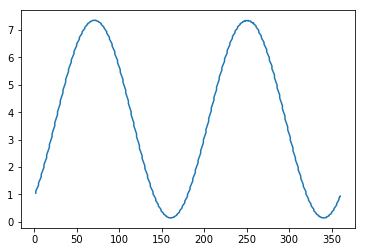

In [25]:
plt.figure()
plt.plot(posiciones[:,3], intensities)
plt.show()

In [26]:
motors.VELS=[50,50,50,50]
motors.move(
        positions=[0, 0,0,0], velocities=Vels, verbose=False)
motors.get_position()
get_intensity(verbose=True)

current positions = ([ 0.], [ 0.], [ 0.], [ 0.])
0.94, 

0.9427383181173354

In [27]:
positions=posiciones[:,3]


## Fitting data to sine

Fit examples with sinusoidal functions

In [28]:
from scipy import optimize

In [29]:
# Fit the first set
fitfunc = lambda p, x: p[0]+p[1]*np.cos(2*np.pi/p[2]*(x-p[3])) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function


In [30]:
p0 = [1.25,2.5, 180, 0.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(positions, intensities))

if p1[1]<0:
    p_changed=[p1[0], -p1[1], p1[2], p1[3]+90]
    p1=p_changed

y_fitting=fitfunc(p1, positions)
residuals=intensities-y_fitting


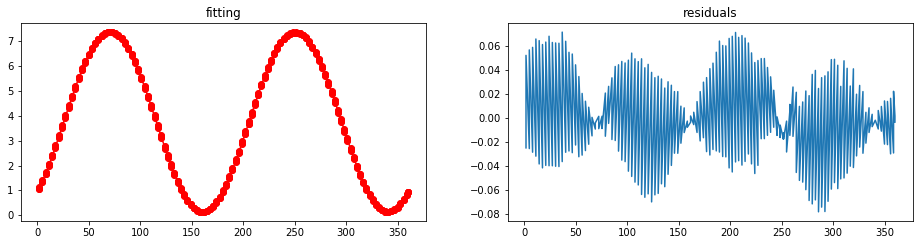

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(positions, intensities, "ro")
plt.plot(positions,y_fitting , "r-") # Plot of the data and the fit

#p_changed=[p1[0], -p1[1], p1[2], p1[3]+90]
#y_fitting_changed=fitfunc(p_changed, positions)
#plt.plot(positions, y_fitting_changed, 'g')

plt.title('fitting')

plt.subplot(2,2,2)
plt.plot(positions, residuals)
plt.title('residuals')
plt.show()

In [32]:
print(p1)
print(sp.std(residuals))

[3.7526601429615964, 3.6116444298692505, 179.85834831189621, 70.788294100307255]
0.030283930352


## Analysis of results

In [33]:
angle4_max=p1[3]
min_light=p1[0]-p1[1]
max_light=p1[0]+p1[1]

print("angle = {} º, min_intensity = {} V, max_intensity ={}".format(angle4_max, min_light, max_light))
print("intensities: min = {}, max = {}".format(intensities.min(), intensities.max()))

angle = 70.7882941003 º, min_intensity = 0.141015713092 V, max_intensity =7.36430457283
intensities: min = 0.139393431367, max = 7.35926371929


### Go to Maximum intensity position

In [34]:
motors.move(
        positions=[0, 0, 0, angle4_max], velocities=Vels, verbose=False)
motors.get_position()
get_intensity(verbose=True)

current positions = ([ 0.], [ 0.], [ 0.], [ 70.782])
7.36, 

7.359263719292358

### Go to Minimum intensity position

In [36]:
motors.move(
        positions=[0, 0, 0, angle4_max+90], velocities=Vels, verbose=False)
motors.get_position()
get_intensity(verbose=True)

current positions = ([ 0.], [ 0.], [ 0.], [ 160.782])
0.14, 

0.1393934313673526

## Final: Close

In [37]:
motors.close()
del motors
LabJackPython.Close()

## TO DO

* change positions of motors from 2->1 and from 3->4

* if p[1]<0 change sign and add 90º